## NSMC 정제하기
- Naver sentiment movie corpus

* 감정분석을 위해, Naver Movie Corpus(https://github.com/e9t/nsmc/) 를 사용합니다.

In [1]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
            documents = [line.split('\t') for line in f.read().splitlines()]
            documents = documents[1:]
    return documents
    
train_docs = read_documents("./data/nsmc/ratings_train.txt")
test_docs = read_documents("./data/nsmc/ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


### 함수 정의.

In [3]:
import re

def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile('.*\t[A-Z]+')
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split('\t')) for token in mecab.parse(text).splitlines()[:-1]]    
        
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if re.match('N[A-Z]+', token[1]):
            nouns.append(token[0])
    return nouns

def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+")
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]] 
    
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs

def mecab_pos(text):
    pos = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    # re()보다 re.compile()로 해서 미리 컴파일해두면 속도가 더 빠름
    pattern = re.compile(".*\t[A-Z]+") # 토큰이름, 탭, 품사종류
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    # group(0) -> 생성된 객체에서 스트링만 뽑아줌
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
    
    return pos

In [4]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

### 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [5]:
import MeCab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

okt = Okt()
mecab = MeCab.Tagger()

SW = define_stopwords("./data/stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
#     train_data = []
#     for line in train_docs:
#         if text_tokenizing(line[1]):
#             train_data.append((text_tokenzing(line[1]), line[2]))
    
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


### NLTK를 이용한 histogram 분석.

* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

In [10]:
train_data[:4]

[[['진짜', '짜증', '네요', '목소리'], '0'],
 [['..', '포스터', '보고', '초딩', '영화', '...', '오버', '연기', '조차', '가볍', '구나'], '1'],
 [['너무', '밓었다그래서보는것을추천한다'], '0'],
 [['교도소', '이야기', '구먼', '솔직히', '재미', '평점', '조정'], '0']]

In [6]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1206841


In [11]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

51722
[('영화', 57614),
 ('..', 22813),
 ('는데', 11543),
 ('너무', 11002),
 ('정말', 9783),
 ('으로', 9322),
 ('네요', 9053),
 ('재밌', 9022),
 ('지만', 8366),
 ('진짜', 8326)]


### Histogram 그리기.

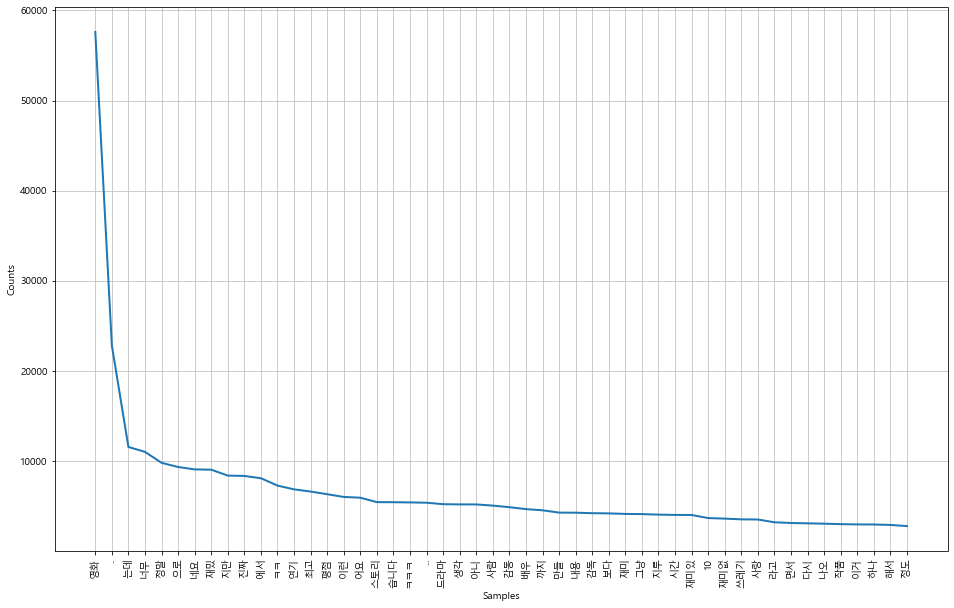

In [12]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

### WordCloud 그리기.

In [15]:
# !pip install wordcloud

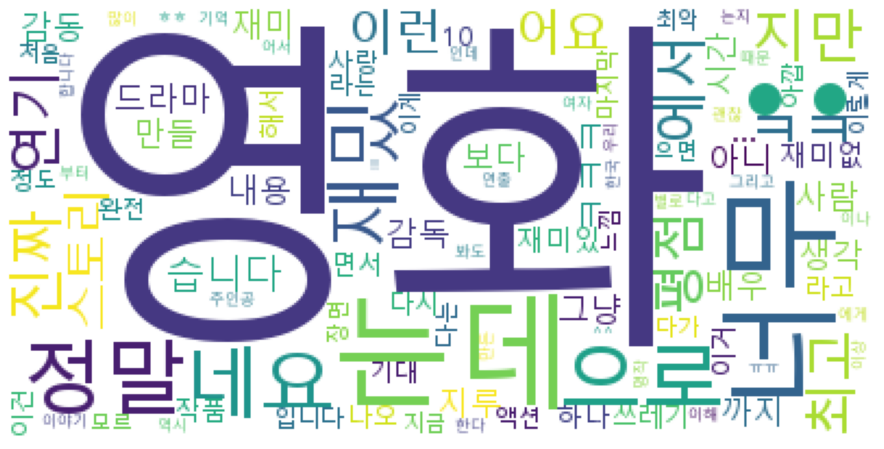

In [17]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

# for win : font_path='c:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()